# MODERN SOUNDING PLOTTER
___________________

#### BY KYLE J GILLETT (@WXKYLEGILLETT) 2022

In [1]:
"""
    > This script was written by Kyle Gillett (@wxkylegillett) (2022)
    
    > The task of this script is to retrieve RAOB data, preform a number of calculations, and plot the data 
      on a Skew-T & hodograph.
    
    > The purpose of this script is to provide a modern, clean, clear, and concise sounding plot that makes
      for quick and easy assessment of the data for environmental analysis purposes, focused on severe weather.
      
    > It should be noted that, as with any sounding plot, many of the calculations & plotting operations here
      shoulder heavy assumptions, and these assumptions should be well understood to get the most out of any 
      sounding plot.
      
    > Numerous python libraries are utilized throughout this script, including MetPy and SharpPy's python packages. 
      Several packages here may need to be installed to run this code. 
      
    > If you happen to run into any bugs, have questions or ideas, please message me on Twitter (@wxkylegillett) 
      or open an issue on GitHub.
      
    > You will be able to plot tornado tracks and storm reports from the SPC. Please note: tornado tracks as of 12/22 are only
      available between 1950 and 2021. If you are plotting a date in 2022 or 2023 - turn off plot_TorTracks. SPC Storm Reports 
      should be availible now through June 1st, 1999. Missing or bad data is possible.
      
    > You can turn on reports or tracks by setting plot_TorTracks, plot_TorReports, plot_WindReports, & plot_HailReports equal
      to True, or off by setting them to False. 
      
    > Each cell requiring user input will be clearly marked with instructions 
    
"""

# IMPORTS ----------------------------------------------------------------------------------------------------
# Basic Software
import warnings                                                                  
warnings.filterwarnings("ignore")    
import pandas           as pd
import numpy            as np
import numpy.ma         as ma
import math
# Matplotlib software
import matplotlib.pyplot as plt
import matplotlib.lines  as mlines
# time software
from dateutil           import tz
from timezonefinder     import TimezoneFinder
from datetime           import datetime, timedelta
# Metpy software 
import metpy.calc       as mpcalc
from metpy.plots        import add_metpy_logo, add_unidata_logo, add_timestamp, SkewT, Hodograph
from metpy.units        import units
# siphon software
from siphon.simplewebservice.wyoming import WyomingUpperAir
# sharppy software
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils 
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo
import sharppy.sharptab.constants as const
print("[+] IMPORTS COMPLETE")

# STATION DICTIONARY - note: this script will plot any sounding location, but not all locations are included in this dict
#                      if you plot a station not in this dict, there will be an option to set your own City Name & State
stations = {
    # 'Station Id': ['Station City Name', 'State/Province Abrv', State/Province Name']
    # ----------- UNITED STATES ----------
    #-- GREAT LAKES-----------------------
    'DTX': ["Detroit", "MI", "Michigan"],
    'APX': ["Gaylord", "MI", "Michigan"],
    'GRB': ["Green Bay", "WI", 'Wisconsin'],
    'MPX': ["Twin Cities", "MN", 'Minnesota'],
    'INL': ["International Falls", "MN", 'Minnesota'],
    'DVN': ["Davenport", "IA", "Iowa"],
    'ILX': ["Lincoln", "IL", "Illinois"],
    'ILN': ["Wilmington", "OH", "Ohio"],
    #-- NORTHEAST ----------------------
    'PIT': ["Pittsburgh", "PA", "Pennsylvania"],
    'BUF': ["Buffalo", "NY", "New York"],
    'ALB': ["Albany", "NY", "New York"],
    'GYX': ["Gray", "ME", "Maine"],
    'CAR': ["Caribou", "ME", "Maine"],
    #--- THE SOUTH ---------------------
    'IAD': ["Sterling", "VA", "Virginia"],
    'WAL': ["Wallops Island", "VA", "Virginia"],
    'RNK': ["Blacksburg", "VA", "Virginia"],
    'GSO': ["Greensboro", "NC", "North Carolina"],
    'MHX': ["Newport", "NC", "North Carolina"],
    'CHS': ["Charleston", "SC", "South Carolina"], 
    'BNA': ["Nashville", "TN", "Tennessee"],
    'FFC': ["Peachtree City", "GA", "Georgia"],
    'BMX': ["Shelby County Airport", "AL", "Alabama"],
    'JAX': ["Jacksonville", "FL", "Florida"],
    'TLH': ["Tallahassee", "FL", "Florida"],
    'TBW': ["Tampa Bay", "FL", "Florida"],
    'MFL': ["Miami", "FL", "Florida"],
    'KEY': ["Key West", "FL", "Florida"],
    'LIX': ["Slidell Muni", "LA", "Louisiana"],
    'LCH': ["Lake Charles", "LA", "Louisiana"],
    'SHV': ["Shreveport", "LA", "Louisiana"],
    'JAN': ["Jackson", "MS", "Mississippi"],
    'LZK': ["Little Rock", "AR", "Arkansas"], 
    #-- SOUTHERN PLAINS ------------------
    'SGF': ["Springfield", "MO", "Missouri"],
    'CRP': ["Corpus Christi", "TX", "Texas"],
    'FWD': ["Dallas", "TX", "Texas"],
    'DRT': ["Del Rio", "TX", "Texas"],
    'MAF': ["Midland", "TX", "Texas"],
    'BRO': ["Brownsville", "TX", "Texas"],
    'EPZ': ["Santa Teresa", "TX",  "Texas"],
    'AMA': ["Amarillo", "TX", "Texas"],
    'OUN': ["Norman", "OK", "Oklahoma"],
    'LMN': ["Lamont", "OK", "Oklahoma"],
    'DDC': ["Dodge City", "KS", "Kansas"],
    'TOP': ["Topeka", "KS", "Kansas"],
    #-- NORTHERN & HIGH PLAINS ------------
    'LBF': ["North Platte", "NE", "Nebraska"],
    'OAX': ["Omaha", "NE", "Nebraska"],
    'RAP': ["Rapid City", "SD", "South Dakota"],
    'ABR': ["Aberdeen", "SD", "South Dakota"],
    'BIS': ["Bismarck", "ND", "North Dakota"],
    'TFX': ["Great Falls", "MT", "Montana"],
    'RIW': ["Riverton", "WY", "Wyoming"],
    'DNR': ["Denver", "CO", "Colorado"],
    #-- ROCKIES AND NORTHWEST -------------
    'OTX': ["Spokane", "WA", "Washington"],
    'UIL': ["Quillayute", "WA", "Washington"],
    'SLE': ["Salem", "OR", "Oregon"],
    'MFR': ["Medford", "OR", "Oregon"],
    'BOI': ["Boise", "ID", "Idaho"],
    'LKN': ["Elko", "NV", "Nevada"],
    'SLC': ["Salt Lake City", "NV", "Nevada"],
    'GJT': ["Grand Juction", "CO", "Colorado"],
    #-- SOUTHWEST ------------------------
    'REV': ["Reno", "NV", "Nevada"],
    'VEF': ["Las Vegas", "NV", "Nevada"],
    'FGZ': ["Flagstaff", "AZ", "Arizona"],
    'TUS': ["Tucson", "AZ", "Arizona"],
    'ABQ': ["Albuquerque", "NM", "New Mexico"],
    'NKX': ["San Diego", "CA", "California"],
    'VBG': ["Vandenberg AFB", "CA", "California"],
    'OAK': ["Oakland", "CA", "California"],
    #-- ALASKA ---------------------------
    'PANT': ["Annette Island", "AK", "Alaska"],
    'PAYA': ["Yakutat", "AK", "Alaska"],
    'PADQ': ["Kodiak", "AK", "Alaska"],
    'PACD': ["Cold Bay", "AK", "Alaska"],
    'PASY': ["Shemya AFB", "AK", "Alaska"],
    'PASN': ["St. Paul", "AK", "Alaska"],
    'PAKN': ["King Salmon", "AK", "Alaska"],
    'PANC': ["Anchorage", "AK", "Alaska"],
    'PABE': ["Bethel", "AK", "Alaska"],
    'PAMC': ["Mcgrath", "AK", "Alaska"],
    'PAFA': ["Fairbanks", "AK", "Alaska"],
    'PAOM': ["Nome", "AK", "Alaska"],
    'PAOT': ["Kotzebue, Ralph Wien", "AK", "Alaska"],
    'PABR': ["Barrow", "AK", "Alaska"],
    #-------------- CANADA ---------------
    #--Nova Scotia ----------------------
    'YQI': ["Yarmouth", "NS", "Nova Soctia"],
    'AWE': ["Shearwater", "NS", "Nova Soctia"],
    #--Newfoundland ---------------------
    'YYR': ["Goose Bay", "NF", "Newfoundland"],
    'YJT': ["Stephenville", "NF", "Newfoundland"],
    'AYT': ["Mt Pearl", "NF", "Newfoundland"],
    #--Quebec --------------------------
    'WPH': ["Inukjuak", "QB", "Quebec"],
    'YVP': ["Kuujjuaq", "QB", "Quebec"],
    'WMW': ["Maniwaki", "QB", "Quebec"],
    'YAH': ["La Grande Iv", "QB", "Quebec"],
    'YZV': ["Sept-Iles", "QB", "Quebec"],
    #--Ontario -------------------------
    'YMO': ["Moosonee", "ON", "Ontario"],
    'WPL': ["Pickle Lake", "ON", "Ontario"],
    #--Manitoba ------------------------    
    'YYQ': ["Churchill", "MB", "Manitoba"],
    'YQD': ["The Pas", "MB", "Manitoba"],
    #--Alberta -------------------------
    'WSE': ["Edmonton Stony Plain", "AB", "Alberta"],
    #--British Columbia ---------------
    'CWVK':["Vernon", "BC", "British Columbia"],
    'ZXS': ["Prince George", "BC", "British Columbia"],
    'YYE': ["Fort Nelson", "BC", "British Columbia"],
    'YZT': ["Port Hardy", "BC", "British Columbia"],
    #--Yukon --------------------------
    'YXY': ["Whitehorse", "YT", "Yukon"],
    #--Northwest Territories ----------
    'YVQ': ["Norman Wells Ua", "NT", "Northwest Territories"],
    'YEV': ["Inuvik", "NT", "Northwest Territories"],
    'YBK': ["Baker Lake", "NT", "Northwest Territories"],
    'YCB': ["Cambridge Bay", "NT", "Northwest Territories"],
    'YUX': ["Hall Beach", "NT", "Northerst Territories"],
    'YFB': ["Iqaluit", "NT", "Northerst Territories"],
    #-- ATLANTIC ISLANDS------------------
    'TJSJ': ["San Juan", "PR", "Puerto Rico"],
    'MDSD': ["Santo Domingo", "DO", "Dominican Republic"]
    
}

[+] IMPORTS COMPLETE


In [133]:
# USER DATA------------------------------
your_name = 'YOUR NAME'  # add your name here to add it to the plot!
utc_year  = '2022'          # launch year                          
utc_month = '12'            # launch month
utc_day   = '29'            # launch day
utc_hour  = '00'            # launch hour 
station   = 'DTX'           # 3 digit station id

plot_TorReports = True      # set equal to True or False if you want SPC torn reports plotted or not
plot_HailReports = True     # set equal to True or False if you want SPC hail reports plotted or not 
plot_WindReports = True     # set equal to True or False if you want SPC wind reports plotted or not 
plot_TorTracks = False       # set equal to True or False if you want SPC torn track reports plotted NOTE (currently 1950-2021 ONLY)

# SET CITY AND STATE LOCATION FOR TITLE
city = str(stations[station][0])  # this line sets the city corresponding to the station id via the dict in the previous cell - turn off by commenting a #
state = str(stations[station][1]) # this line sets the state abrv. corresponding to the station id via the dict in the previous cell - turn off by commenting a #
#city = 'Norman' # this line allows the user to manually set the city name if its not present in th dict in the previous cell
#state = 'OK' # this line allows the user to manually set the city name if its not present in th dict in the previous cell

# SET UTC DATETIME OBJECT
utc_date = datetime(int(utc_year), int(utc_month), int(utc_day), int(utc_hour))  # create datetime object with UTC launch data

# RETRIEVE DATA FROM WYOMING UPPER AIR
for i in range(1, 11):
    try: 
        df = WyomingUpperAir.request_data(utc_date, station)
        worked = True
        print(f'[+] DATA RETRIEVAL ATTEMPT [{i}] WAS SUCCESSFUL')
        if worked == True:
            print(f'<> DATA RETRIEVAL OPERATIONS COMPLETE <>')
            break
    except:
        print(f'[!] DATA RETRIEVAL ATTEMPT [{i}] FAILED - UnvWym Server Failure')
    pass

# PARSE PRESSURE, TEMPERATRUE, DEWPOINT, WIND, HEIGHT, ETC FROM THE DATA FRAME        
p1     = df['pressure'].values    * units(df.units['pressure'])      # parse raw pressure array 
T1     = df['temperature'].values * units(df.units['temperature'])   # parse raw temperature array
Td1    = df['dewpoint'].values    * units(df.units['dewpoint'])      # parse raw dewpoint array
wd1    = df['direction'].values   * units.degrees                    # parse raw wind direction array
ws1    = df['speed'].values       * units(df.units['speed'])         # parse raw wind speed array
u1, v1 = mpcalc.wind_components(ws1, wd1)                            # calc raw u and v wind components 
hgt1   = df['height'].values * units(df.units['height'])             # parse raw height values 
z_AGL  =(df['height']-df['elevation']).values * units.m              # parse and calc raw height AGL array
lat    = df['latitude']                                              # parse station lat
lon    = df['longitude']                                             # parse station lon
stn_elevation_m  = np.round(df['elevation'].values)* units.m         # parse stn elevation (m)
stn_elevation_ft = np.round((stn_elevation_m).to(units.ft),1)        # calculate stn elevation (ft)


# FIX DUPLICATE VALUES & NaNs FOR BETTER CALCULATIONS
non_dups = np.concatenate(([True], np.diff(p1) != 0))
p    = p1[non_dups]
T    = T1[non_dups]
Td   = Td1[non_dups]
hgt1 = hgt1[non_dups]
z_AGL= z_AGL[non_dups]
ws   = ws1[non_dups]
wd   = wd1[non_dups]
u    = u1[non_dups]
v    = v1[non_dups]

ws   = np.nan_to_num(ws, nan=0*units.kts)
wd   = np.nan_to_num(wd, nan=0*units.degrees)
u    = np.nan_to_num(u, nan=0*units.kts)
v    = np.nan_to_num(v, nan=0*units.kts)
hgt = np.nan_to_num(hgt1, nan=(hgt1[-2]+100*units.m)) # often times final hgt value is nan but its unused data, so a 'rigged fix' is used to put it through calcs without error
p    = np.nan_to_num(p, nan=0*units.hPa)


# DETERMINE LOCAL DATE FOR STORM REPORTS AND TORNADO TRACKS 
tzFinder = TimezoneFinder()  # reuse
timeZone = tzFinder.timezone_at(lng=lon[0], lat=lat[0])
timeZoneAbrv = {
    'America/Detroit': 'ET',
    'America/Indiana/Indianapolis': 'ET',
    'America/New_York': 'ET',
    'America/Chicago': 'CT',
    'America/Denver': 'MT',
    'America/Los_Angeles': 'PT',
    'America/Edmonton': 'CT'
}

from_zone = tz.gettz('UTC')               # 'from'-time zone (always UTC)
to_zone = tz.gettz(timeZone)              # 'to'-time zone (set to the time zone for each station)
utc = utc_date.replace(tzinfo=from_zone)  # tell UTC datetime object that it is in UTC time
local_date = utc.astimezone(to_zone)      # convert UTC datetime object to local datetime object

local_hour = local_date.strftime("%I %p") # determine local hour in 12hr format
local_day  = local_date.strftime("%d")    # determine local day
local_month = local_date.strftime("%m")   # determine local month
local_year = local_date.strftime("%Y")    # determine local year
print('________________________________________') 

[+] DATA RETRIEVAL ATTEMPT [1] WAS SUCCESSFUL
<> DATA RETRIEVAL OPERATIONS COMPLETE <>
________________________________________


### CALCULATIONS

In [134]:
######################################### SHARRPY AND BASIC VALUE CALCULATIONS ##############################################
# SHARPPY GENERAL & CONVECTIVE PROFILE CREATION
try:
    prof = profile.create_profile(profile='default', pres=p.m, hght=z_AGL.m, tmpc=T.m, \
                                    dwpc=Td.m, wspd=ws, wdir=wd, missing=-9999, strictQC=True)
    convect_prof = sharppy.sharptab.profile.ConvectiveProfile(pres=p.m, hght=z_AGL.m, tmpc=T.m, 
                                    dwpc=Td.m, wspd=ws, wdir=wd, location=station, date=utc_date)
    sharppyFailed = False 
except:
    print("[*] SHARPPY FAILED")
    sharppyFailed = True
    pass

# CALCULATE OTHER VALUES-------------------------------
Tw = mpcalc.wet_bulb_temperature(p, T, Td)             # WETBULB TEMP
q = mpcalc.specific_humidity_from_dewpoint(p, Td)      # SPECIFIC HUMIDITY
w = mpcalc.mixing_ratio_from_specific_humidity(q)      # MIXING RATIO
Tv = mpcalc.virtual_temperature(T, w)                  # VIRTUAL TEMP
T_degF = np.round(T.to(units.degF), 1)                 # CONVERT T TO DEGF
Td_degF = np.round(Td.to(units.degF), 1)               # CONVERT TD TO DEGF
theta = np.round(mpcalc.potential_temperature(p, T),1) # THETA
theta_e = np.round(mpcalc.equivalent_potential_temperature(p, T, Td),1)   # THETA E

#CALCULATE SPECIAL PARAMETERS 
pwat = np.round(mpcalc.precipitable_water(p, Td).to('in'), 1)           # calc & round PWAT
r = mpcalc.relative_humidity_from_dewpoint(T, Td)                       # calculate r
RH = np.round((r*100),1)                                                # calculate RH from r
w_raw = mpcalc.mixing_ratio_from_relative_humidity(p, T, r)             # calculate mixing ratio
w = np.round((w_raw*1000),1)*units.g/units.kg                           # convert to g/kg and define units
mean_w = np.round(sum(w)/len(w), 1)                                     # find mean mixing ratio

roseDirection = mpcalc.angle_to_direction(wd[0], full=False, level=3)   # calculate compass rose direction
print("[+] GENERAL CALCULATIONS COMPLETE")

# POSSIBLE HZRDS (WATCH_TYPE), PTYPE, INITAL PHASE AND WINDCHILL FROM SHARPPY PROFILES
watch_type = sharppy.sharptab.watch_type.possible_watch(convect_prof, use_left=False)
ptype = convect_prof.precip_type


# TEXT COLORS FOR WATCH TYPE DATA TEXT PLOTS
watch_type_txt_clr = {
    'NONE': 'green',
    'MRGL SVR': 'steelblue',
    'SVR': 'orange',
    'MRGL TOR': 'red',
    'TOR': 'red',
    'PDS TOR': 'magenta',
    'FLASH FLOOD': 'lawngreen',
    'BLIZZARD': 'blue',
    'WIND CHILL': 'cornflowerblue',
    'FREEZE': 'mediumblue',
    'FIRE WEATHER': 'orange',
    'EXESSIVE HEAT': 'pink'
}

ptype_txt_clr = {
    'None.': 'brown',
    'Rain.': 'green',
    'Snow.': 'blue',
    'Freezing Rain/Drizzle.': 'purple'
}

if ptype == 'Freezing Rain/Drizzle.':
    ptype = 'ZR / DRZL'

DGZ_ptype_txt_clr = {
    'None':'brown',
    'Rain':'green',
    'Snow':'blue',
    'Freezing Rain':'purple'
} 


try:
    print("[+] SHARPPY WATCH TYPE AND PRECIP TYPE ESITMATIONS COMPLETE")
    print("    --------")
    print('    > WATCH TYPE: ', watch_type[0], " | PRECIP TYPE: ", ptype)
    
    #BEGIN SARS DATABASE SCRIPT 
    from sharppy.io.spc_decoder import SPCDecoder
    import sharppy.databases.sars as sars
    try:
        supercell_matches = convect_prof.supercell_matches
        hail_matches = convect_prof.matches
    except:
        supercell_matches = convect_prof.right_supercell_matches
        hail_matches = convect_prof.right_matches

    print("[+] SARS DATABASE MATCHING COMPLETE")
    print("    --------")
    for mtype, matches in zip(['Supercell', 'Hail'], [supercell_matches, hail_matches]):
        print('    > ' + mtype + ' MATCHES')
        print('    -----------')
        if len(matches[0]) == 0:
            print("    > NO QUALITY MATCHES")
        for i in range(len(matches[0])):
            print('    > '+matches[0][i] + ' ' + str(matches[1][i]))
        print("    > Total Loose Matches:", matches[2])
        print("    > # of Loose Matches that met Criteria:", matches[3])
        print("    > SVR Probability:", matches[4])
        print(' ')    
except:
    pass
print("[+] SARS OUTPUT COMPLETE") 
############################################################################################################################

############################################## PARCEL PROPERTIES ############################################################
if sharppyFailed == False:
    # SURFACE PARCEL ----------------------------------------------------------------------------------------------
    sbpcl = params.parcelx(prof, flag=1, pres=p[0].m, tmpc=T[0].m, dwpc=Td[0].m)          # create sfc parcel object
    sbT_trace = sbpcl.ttrace*units.degC                                                   # create sfc parcel T trace 
    sbP_trace = sbpcl.ptrace*units.hPa                                                    # create sfc parcel P trace 
    sb_lcl_p   = int(sbpcl.lclpres) *units.hPa                                            # calc SB LCL (hPa)
    sb_lcl_hgt = int(sbpcl.lclhght) *units.m                                              # calc SB LCL (m) 
    try:                                                                                  # try SHARPPY height calcs 
        sb_lfc_p   = int(sbpcl.lfcpres) *units.hPa                                        # calc SB LFC (hPa)
        sb_lfc_hgt = int(sbpcl.lfchght) *units.m                                          # calc SB LFC (m)
        sb_el_p    = int(sbpcl.elpres ) *units.hPa                                        # calc SB EL(hPa)
        sb_el_hgt  = int(sbpcl.elhght ) *units.m                                          # calc SB EL (m)
        #sb_mpl_hgt = int(sbpcl.mplhght) *units.m                                          # calc SB MPL (m)
    except:                                                                               # upon failure, set all to NaN
        sb_lfc_p         =  float("NaN")*units.hPa                                        # set SB LFC p to 'Nan' 
        sb_lfc_hgt       =  float("NaN")*units.m                                          # set SB LFC m to 'Nan' 
        sb_el_p          =  float("NaN")*units.hPa                                        # set SB EL p to 'Nan'
        sb_el_hgt        =  float("NaN")*units.m                                          # set SB EL m to 'Nan'
        sb_mpl_hgt       =  float("NaN")*units.m                                          # set SB MPL m to 'Nan'
        pass
    # buoyancy 
    sbcape  = int(sbpcl.bplus)                                                            # calc SBCAPE
    sbcin   = int(sbpcl.bminus)                                                           # calc SBCIN
    sb3cape = int(sbpcl.b3km)                                                             # calc SB 3CAPE
    sb6cape = int(sbpcl.b6km)                                                             # calc SB 6CAPE
    sb_li    = int(sbpcl.li5)                                                             # calc SB LI

    # MIXED PARCEL ------------------------------------------------------------------------------------------------
    depth = (p[0].m - interp.pres(prof, interp.to_msl(prof, 1000)))*units.hPa             # calculate mixed layer depth
    mlpcl_p, mlpcl_T, mlpcl_Td = mpcalc.mixed_parcel(p, T, Td, depth=depth)[0:3]          # create METPY mixed parcel lvl
    mlpcl = params.parcelx(prof, flag=5, pres=mlpcl_p.m, tmpc=mlpcl_T.m, dwpc=mlpcl_Td.m) # create SHARPPY mixed parcel object
    mlT_trace = mlpcl.ttrace.tolist()*units.degC                                          # define mixed parcel T trace 
    mlP_trace = mlpcl.ptrace.tolist()*units.hPa                                           # define mixed parcel P trace 
    ml_lcl_p   = int(mlpcl.lclpres) *units.hPa                                            # calc ML LCL (hPa)
    ml_lcl_hgt = int(mlpcl.lclhght) *units.m                                              # calc ML LCL (m) 
    try:                                                                                  # try sharppy height calcs 
        ml_lfc_p   = int(mlpcl.lfcpres) *units.hPa                                        # calc ML LFC (hPa)
        ml_lfc_hgt = int(mlpcl.lfchght) *units.m                                          # calc ML LFC (m)
        ml_el_p    = int(mlpcl.elpres ) *units.hPa                                        # calc ML EL (hPa)
        ml_el_hgt  = int(mlpcl.elhght ) *units.m                                          # calc ML EL (m)
    except:                                                                               # upon failure, set heights = NaN
        ml_lfc_p         =  float("NaN") *units.hPa                                       # set to NaN 
        ml_lfc_hgt       =  float("NaN") *units.m                                         # set to NaN 
        ml_el_p          =  float("NaN") *units.hPa                                       # set to NaN
        ml_el_hgt        =  float("NaN") *units.m                                         # set to NaN
        pass
    # buoyancy 
    mlcape  = int(mlpcl.bplus)                                                            # calc MLCAPE 
    mlcin   = int(mlpcl.bminus)                                                           # calc MLCIN
    ml3cape = int(mlpcl.b3km)                                                             # calc ML 3CAPE
    ml6cape = int(mlpcl.b6km)                                                             # calc ML 6CAPE 
    ml_li   = int(mlpcl.li5)                                                              # calc ML LI

    p_ML03, T_ML03 = mpcalc.get_layer(mlP_trace, mlT_trace, depth=3*units.km)             # get_layer for 0-3km ML parcel
    p_ML06, T_ML06 = mpcalc.get_layer(mlP_trace, mlT_trace, depth=6*units.km)             # get_layer for 0-6km ML parcel


    # MOST UNSTABLE PARCEL ---------------------------------------------------------------------------------------
    mupcl_p, mupcl_T, mupcl_Td = mpcalc.most_unstable_parcel(p, T, Td, depth=depth)[0:3]
    mupcl = params.parcelx(prof, flag=3, pres=mupcl_p.m, tmpc=mupcl_T.m, dwpc=mupcl_Td.m)
    muT_trace = mupcl.ttrace*units.degC
    muP_trace = mupcl.ptrace*units.hPa
    mu_lcl_p   = int(mupcl.lclpres) *units.hPa
    mu_lcl_hgt = int(mupcl.lclhght) *units.m
    try:                                                                                  # try sharppy height calcs 
        mu_lfc_p   = int(mupcl.lfcpres) *units.hPa                                        # calc ML LFC (hPa)
        mu_lfc_hgt = int(mupcl.lfchght) *units.m                                          # calc ML LFC (m)
        mu_el_p    = int(mupcl.elpres ) *units.hPa                                        # calc ML EL (hPa)
        mu_el_hgt  = int(mupcl.elhght ) *units.m                                          # calc ML EL (m)
    except:                                                                               # upon failure, set heights = NaN
        mu_lfc_p         =  float("NaN") *units.hPa                                       # set to NaN 
        mu_lfc_hgt       =  float("NaN") *units.m                                         # set to NaN 
        mu_el_p          =  float("NaN") *units.hPa                                       # set to NaN
        mu_el_hgt        =  float("NaN") *units.m                                         # set to NaN
        pass
    # buoyancy 
    mucape  = int(mupcl.bplus)
    mu_cape = mupcl.bplus
    mucin   = int(mupcl.bminus)
    mu3cape = int(mupcl.b3km)
    mu6cape = int(mupcl.b6km)
    mu_li   = int(mupcl.li5)   
    
    if math.isnan(mu_lfc_hgt.m) == False:
        try:
            mu_ncape = np.round(mucape / ((mu_el_hgt.m - mu_lfc_hgt.m)),1)                      # calculate normalized MUCAPE
            sb_ncape = np.round(sbcape / ((sb_el_hgt.m - sb_lfc_hgt.m)),1)                      # calculate normalized SBCAPE
            ml_ncape = np.round(mlcape / ((ml_el_hgt.m - ml_lfc_hgt.m)),1)                      # calculate normalized MLCAPE
        except:                                                                                 # upon failure, set = '-'
            mu_ncape = '-'
            sb_ncape = '-'
            ml_ncape = '-'
            pass
    else:
        mu_ncape = '-'
        sb_ncape = '-'
        ml_ncape = '-'
    print("[+] PARCEL AND THERMODYNAMIC CALCULATIONS COMPLETE")
    
    

# FREEZING POINT CALCULATION------------------------------------------------------------------                                                                    
T_list = T.m.tolist()                                                                  # convert T to list to filter 
res = list(filter(lambda i: i <= 0, T_list))[0]                                        # filter T for 0 degC
frz_pt_index = T_list.index(res)                                                       # define pt where T = 0 degC
frz_pt_p = p[frz_pt_index]                                                             # find pres @ T = 0 degC 
frz_pt_z = hgt[frz_pt_index]                                                           # find height @ T = 0 degC
frz_pt_ft = frz_pt_z.to('ft')               
print('[+] FREEZING POINT CALCULATIONS COMPLETE')

# HAIL GROWTH ZONE CALCULATIONS ---------------------------------------------------------------
hgz = params.hgz(prof)
hgz_deltaz = np.round((interp.hght(prof, hgz[1])-interp.hght(prof, hgz[0])),1)*units.m
pHGZ, tHGZ = mpcalc.get_layer(p, T, bottom=hgz[0]*units.hPa, depth=(hgz[0]-hgz[1])*units.hPa)

# PBL TOP CALCULATION--------------------------------------------------------------------------
pbl_top = params.pbl_top(prof)                                                         # calc SHARPPY PBL top height

# LAPSE RATE CALCULATIONS--------------------------------------------------------------------
if sharppyFailed == False:
    lr_3_6km = sharppy.sharptab.params.lapse_rate(convect_prof, 3000, 6000, pres=False)    # calc 3-6km Lapse Rate
    lr_0_3km = sharppy.sharptab.params.lapse_rate(convect_prof, 0, 3000, pres=False)       # calc 0-3km Lapse Rate 
    LapseMax = params.max_lapse_rate(convect_prof, lower=0, upper=6000, interval=250,      # calc 0-12km Max Lapse Rate
                                 depth=2000)
if sharppyFailed == True:
    lr_3_6km = -999
    lr_0_3km = -999
    LapseMax = -999
print('[+] LAPSE RATE CALCULATIONS COMPLETE')

#  -------------------------------------------- KINEMATIC CALCULATIONS -------------------------------------------------

# EFFECTIVE INFLOW LAYER CALCULATIONS -----------------------------------------------------------
srwind = params.bunkers_storm_motion(prof)
eff_inflow = params.effective_inflow_layer(prof)
ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1])) 
eff_layer = (etop_hght - ebot_hght)
effective_srh = winds.helicity(prof, ebot_hght, etop_hght, stu = srwind[0], stv = srwind[1])*(units.meter*units.meter)/(units.sec*units.sec)
if np.isnan(effective_srh[0]) == True:
        effective_SRH = 'nan'
if np.isnan(effective_srh[0]) == False:
        effective_SRH = int(effective_srh[0].m)      
try:
    EILshr_u, EILshr_v = mpcalc.bulk_shear(p, u.to(units.kts),v.to(units.kts), z, 
                                       bottom =(ebot_hght + z[0].m + 20)*units.m, 
                                       depth=(etop_hght - ebot_hght)*units.m)
    effective_bs = int((np.sqrt(EILshr_u**2 + EILshr_v**2)))
except:
    effective_bs = 'nan'
    pass
if ma.is_masked(eff_layer) == True:
    eff_layer = 0
    
#MEAN SHEAR -------------------------------------------------------------------------
#calculate Bulk Shear for 0-1km, 0-3km, 0-6km, 0-8km.
u_shear005, v_shear005 = mpcalc.bulk_shear(p, u.to(units.kts), v.to(units.kts), depth = 500 * units.meter)
shear005 = np.round((np.sqrt(u_shear005**2 + v_shear005**2)), 1)
u_shear01, v_shear01 = mpcalc.bulk_shear(p, u.to(units.kts), v.to(units.kts), depth = 1000 * units.meter)
shear01 = np.round((np.sqrt(u_shear01**2 + v_shear01**2)), 1)
u_shear03, v_shear03 = mpcalc.bulk_shear(p, u.to(units.kts), v.to(units.kts), depth = 3000 * units.meter)
shear03 = np.round((np.sqrt(u_shear03**2 + v_shear03**2)), 1)
u_shear06, v_shear06 = mpcalc.bulk_shear(p, u.to(units.kts),v.to(units.kts), depth = 6000 * units.meter)
shear06 = np.round((np.sqrt(u_shear06**2 + v_shear06**2)), 1)

if sharppyFailed == False:
    # SHARPPY BUNKERS STORM MOTIONS -------------------------------------------------------------------
    RM_u, RM_v, LM_u, LM_v = params.bunkers_storm_motion(convect_prof)*units.kts 
    #METPY BUNKERS STORM MOTIONS ----------------------------------------------------------------------
    RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, hgt)
    MW_u = MW[0]
    MW_v = MW[1] 
    if ma.is_masked(RM_u) == True or np.isnan(RM_u) == True or sharppyFailed == True:
        RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, hgt)
        MW_u = MW[0]
        MW_v = MW[1] 
        RM_u = RM[0]
        RM_v = RM[1]
        LM_u = LM[0]
        LM_v = LM[1]
        MW_u = MW[0]
        MW_v = MW[1]    
        print("[*] METPY BUNKERS USED")
    
# RM STORM RELATIVE HELICITY -----------------------------------------------------------
# calculate and round positive, negative and total SRH for 0-1km, 0-3km, and 0-6km.
srh_005_pos, srh_005_neg, srh_005_tot = mpcalc.storm_relative_helicity(hgt, u.to(units.kts), v.to(units.kts), 500 * units.meter, bottom = hgt[0], storm_u = RM_u, storm_v = RM_v)
srh_005 = np.round(srh_005_pos, 1)

srh_01_pos, srh_01_neg, srh_01_tot = mpcalc.storm_relative_helicity(hgt, u.to(units.kts), v.to(units.kts), 1000 * units.meter, bottom = hgt[0], storm_u = RM_u, storm_v = RM_v)
srh_01 = np.round(srh_01_pos, 1)
srh_03_pos, srh_03_neg, srh_03_tot = mpcalc.storm_relative_helicity(hgt, u.to(units.kts), v.to(units.kts), 3000 * units.meter, bottom = hgt[0], storm_u = RM_u, storm_v = RM_v)
srh_03 = np.round(srh_03_pos, 1)
srh_06_pos, srh_06_neg, srh_06_tot = mpcalc.storm_relative_helicity(hgt, u.to(units.kts), v.to(units.kts), 6000 * units.meter, bottom = hgt[0], storm_u = RM_u, storm_v = RM_v)
srh_06 = np.round(srh_06_pos, 1)

# METPY SEVERE PARAMETERS -----------------------------------------------------------------
KI = mpcalc.k_index(p, T, Td)                                           # calc K Index
TT = np.round(mpcalc.total_totals_index(p, T, Td), 1)                   # calc & round TT
showalter_index = np.round(mpcalc.showalter_index(p, T, Td), 1)         # calc & round showalter

if sharppyFailed == False:
    u0, v0 = sharppy.sharptab.interp.components(prof, p=interp.pres(prof, interp.to_msl(prof, 0)))
    sru0 = u0 - RM_u.m
    srv0 = v0 - RM_v.m
    sr0_speed = mpcalc.wind_speed(sru0*units.kts, srv0*units.kts)
    sr0_speed = mpcalc.wind_speed(sru0*units.kts, srv0*units.kts)

    u05, v05 = sharppy.sharptab.interp.components(prof, p=interp.pres(prof, interp.to_msl(prof, 500)))
    sru05 = u05 - RM_u.m
    srv05 = v05 - RM_v.m
    sr05_speed = mpcalc.wind_speed(sru05*units.kts, srv05*units.kts)
    
    u1, v1 = sharppy.sharptab.interp.components(prof, p=interp.pres(prof, interp.to_msl(prof, 1000)))
    sru1 = u1 - RM_u.m
    srv1 = v1 - RM_v.m
    sr1_speed = mpcalc.wind_speed(sru1*units.kts, srv1*units.kts)
    
    u3, v3 = sharppy.sharptab.interp.components(prof, p=interp.pres(prof, interp.to_msl(prof, 300)))
    sru3 = u3 - RM_u.m
    srv3 = v3 - RM_v.m
    sr3_speed = mpcalc.wind_speed(sru3*units.kts, srv3*units.kts)

    u6, v6 = sharppy.sharptab.interp.components(prof, p=interp.pres(prof, interp.to_msl(prof, 6000)))
    sru6 = u6 - RM_u.m
    srv6 = v6 - RM_v.m
    sr6_speed = mpcalc.wind_speed(sru6*units.kts, srv0*units.kts)
    sr6_speed = mpcalc.wind_speed(sru6*units.kts, srv0*units.kts)

    u9, v9 = sharppy.sharptab.interp.components(prof, p=interp.pres(prof, interp.to_msl(prof, 9000)))
    sru9 = u9 - RM_u.m
    srv9 = v9 - RM_v.m
    sr9_speed = mpcalc.wind_speed(sru9*units.kts, srv9*units.kts)

    sfc500m_SRwind = (sr05_speed + sr0_speed)/2
    sfc1000m_SRwind = (sr1_speed + sr0_speed)/2
    sfc3000m_SRwind = (sr3_speed + sr0_speed)/2
    sfc6000m_SRwind = (sr6_speed + sr0_speed)/2
    
if sharppyFailed == True: 
    sfc500m_SRwind = -999
    sixToNine_SRwind = -999

# VORTICITY CALCULATIONS 
# interpolate function to intrp u and v data for clean plotting w/ hgt
def interpolate(var,hgts,step):
        levels=np.arange(0,np.max(hgts),step)
        varinterp=np.zeros(len(levels))
        for i in range(0,len(levels)):
            lower=np.where(hgts-levels[i]<=0,hgts-levels[i],-np.inf).argmax()
            varinterp[i]=(((var[lower+1]-var[lower])/(hgts[lower+1]-hgts[lower]))*(levels[i]-hgts[lower])+var[lower])
        return varinterp 
    
resolution=100
pINTRP=p.m[np.isnan(hgt)==False]
uINTRP=u.m[np.isnan(hgt)==False]
vINTRP=v.m[np.isnan(hgt)==False]
zINTRP=hgt.m[np.isnan(hgt)==False]
zINTRP=zINTRP-zINTRP[0]
# Interpolation
pINTRP=interpolate(pINTRP,zINTRP,resolution)
uINTRP=interpolate(uINTRP,zINTRP,resolution)
vINTRP=interpolate(vINTRP,zINTRP,resolution)
zINTRP=interpolate(zINTRP,zINTRP,resolution)

u_ms = uINTRP/1.94384
v_ms = vINTRP/1.94384

uSR = (uINTRP*units.kts - RM_u)/1.94384
vSR = (vINTRP*units.kts - RM_v)/1.94384


# Shear components
dudz=(u_ms[2::]-u_ms[0:-2])/(zINTRP[2::]-zINTRP[0:-2])
dvdz=(v_ms[2::]-v_ms[0:-2])/(zINTRP[2::]-zINTRP[0:-2])
dudz=np.insert(dudz,0,dudz[0])
dudz=np.insert(dudz,-1,dudz[-1])
dvdz=np.insert(dvdz,0,dvdz[0])
dvdz=np.insert(dvdz,-1,dvdz[-1])
# Shear magnitude
shear=np.sqrt(dudz**2+dvdz**2)+0.0000001
# Vorticity components
uvort=-dvdz
vvort=dudz
# Streamwise vorticity
strmw=abs((uSR*uvort+vSR*vvort)/(np.sqrt(uSR**2+vSR**2)))
# Streamwise fraction
strmwperc=(strmw/shear)*100

# layer average streamwise vorticity and SW vort %
strmwperc_05 = np.mean(strmwperc[0:5])
strmwperc_01 = np.mean(strmwperc[0:10])
strmwperc_03 = np.mean(strmwperc[0:30])
strmw_05 = np.mean(strmw[0:5])
strmw_01 = np.mean(strmw[0:10])
strmw_03 = np.mean(strmw[0:30])

print('[+] SHEAR CALCULATIONS COMPLETE')
    
# MEAN RELATIVE HUMIDITY CALCULATIONS ----------------------------------------------------------
RH0_05 = sharppy.sharptab.params.mean_relh(prof, pbot=interp.pres(prof, interp.to_msl(prof, 0000)), ptop=interp.pres(prof, interp.to_msl(prof, 500)))
RH0_1  = sharppy.sharptab.params.mean_relh(prof, pbot=interp.pres(prof, interp.to_msl(prof, 0000)), ptop=interp.pres(prof, interp.to_msl(prof, 1000)))
RH1_3 = sharppy.sharptab.params.mean_relh(prof, pbot=interp.pres(prof, interp.to_msl(prof, 1000)), ptop=interp.pres(prof, interp.to_msl(prof, 3000)))
try: #for lack of data with height 
    RH3_6 = sharppy.sharptab.params.mean_relh(prof, pbot=interp.pres(prof, interp.to_msl(prof, 3000)), ptop=interp.pres(prof, interp.to_msl(prof, 6000)))
    RH6_9= sharppy.sharptab.params.mean_relh(prof, pbot=interp.pres(prof, interp.to_msl(prof, 6000)), ptop=interp.pres(prof, interp.to_msl(prof, 9000)))
except ValueError:
    pass
print('[+] RH CALCULATIONS COMPLETE')
print('____________________________')


[+] GENERAL CALCULATIONS COMPLETE
[+] SHARPPY WATCH TYPE AND PRECIP TYPE ESITMATIONS COMPLETE
    --------
    > WATCH TYPE:  NONE  | PRECIP TYPE:  None.
[+] SARS DATABASE MATCHING COMPLETE
    --------
    > Supercell MATCHES
    -----------
    > NO QUALITY MATCHES
    > Total Loose Matches: 0
    > # of Loose Matches that met Criteria: 0
    > SVR Probability: 0.0
 
    > Hail MATCHES
    -----------
    > NO QUALITY MATCHES
    > Total Loose Matches: 0.0
    > # of Loose Matches that met Criteria: 0.0
    > SVR Probability: 0
 
[+] SARS OUTPUT COMPLETE
[+] PARCEL AND THERMODYNAMIC CALCULATIONS COMPLETE
[+] FREEZING POINT CALCULATIONS COMPLETE
[+] LAPSE RATE CALCULATIONS COMPLETE
[+] SHEAR CALCULATIONS COMPLETE
[+] RH CALCULATIONS COMPLETE
____________________________


### CREATE FIGURE

[+] SKEW T OBJECT CREATION COMPLETE
[+] BASIC SKEW-T PLOTTING COMPLETE
[+] SKEW-T ANNOTATIONS COMPLETE
[+] HODOGRAPH CREATION & PLOTTING COMPLETE
[+] SW ζ & RH (%) PLOTTING COMPLETE
[+] VORTICITY PLOTTING COMPLETE
[+] THETA PLOTTING COMPLETE
[+] SPC WIND REPORT PLOTTING SUCESSFUL
[+] SPC HAIL REPORT PLOTTING SUCESSFUL
[+] SPC TORN REPORT PLOTTING SUCESSFUL
_______________________________________
The sounding is now loading. This may take a second, especially if you plotted reports and/or tornado tracks.


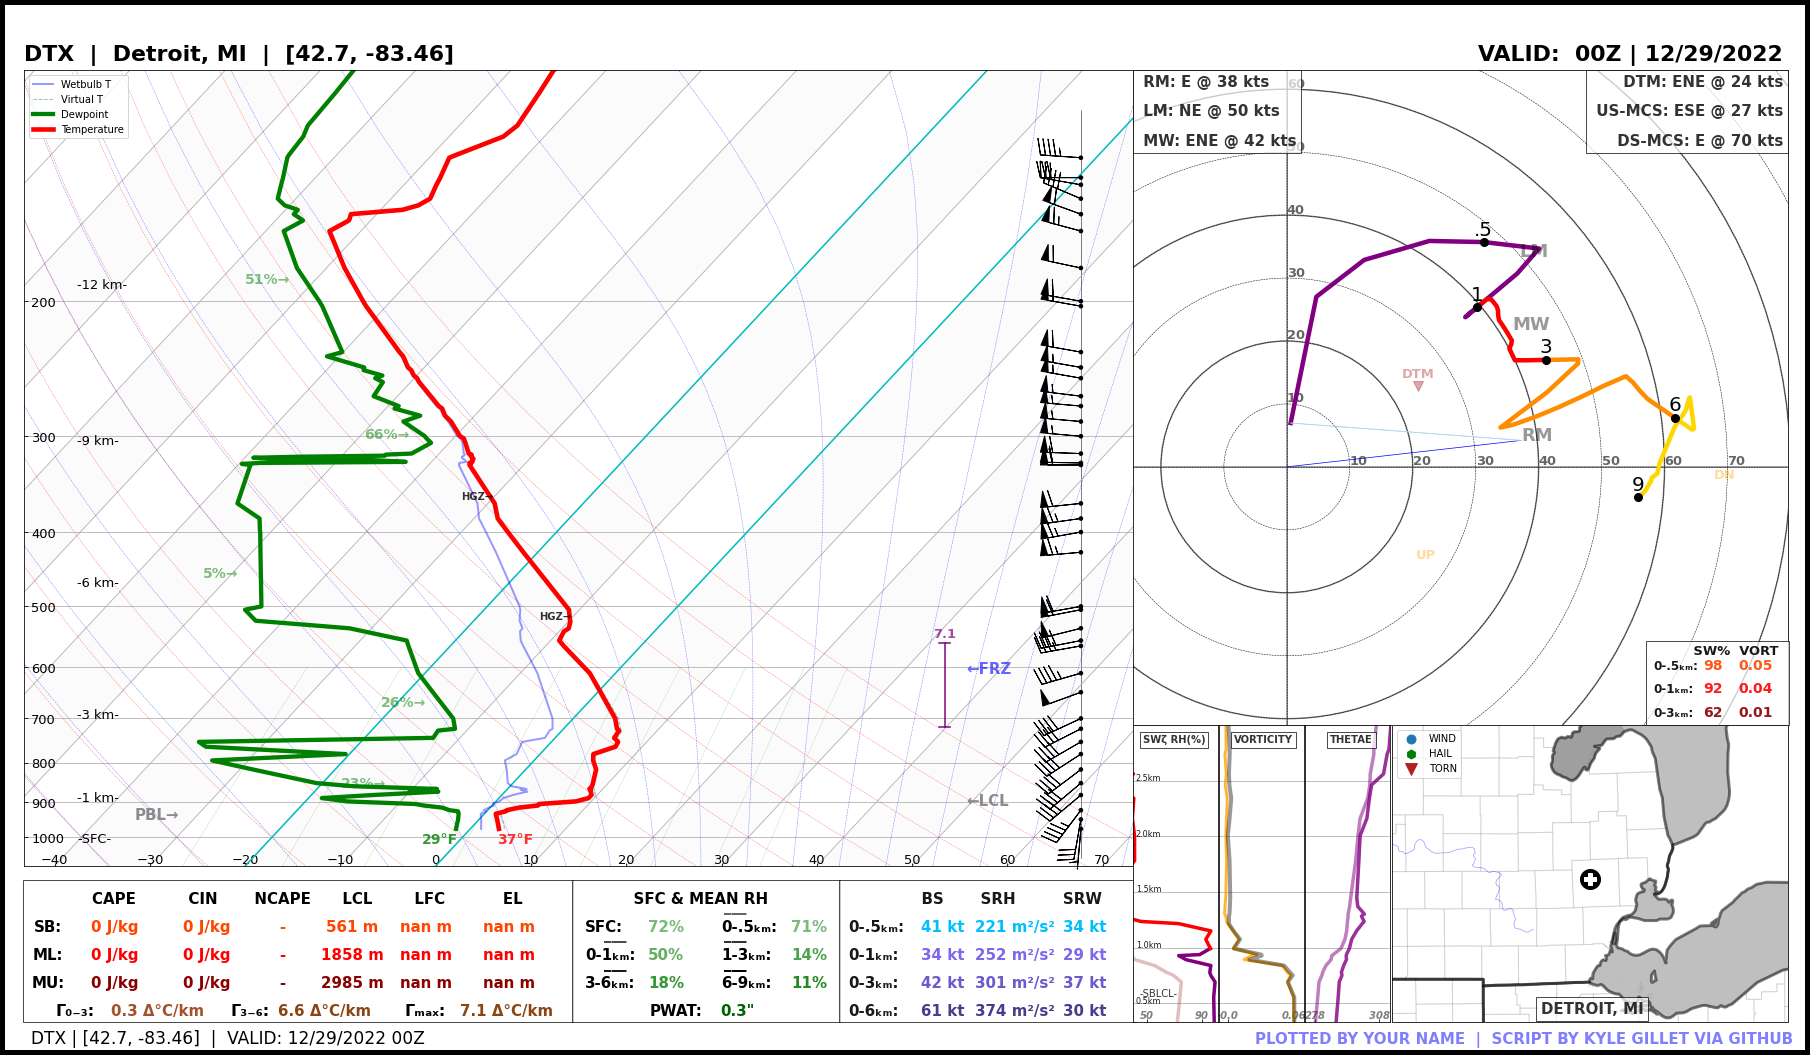

In [135]:
###################################### FIGURE CREATION and SKEW T PROPERTIES ################################################
#CREATE FIGURE-----------------------------------------------------------------------------------
fig = plt.figure(figsize=(22,13), linewidth=10, edgecolor="black")             # create figure                                   # create figure
skew = SkewT(fig, rotation=43, rect=(0.1, 0.1, 0.70, 0.85))                    # create SkewT Object
#AXIS LIMITS ------------------------------------------------------------------------------------
# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')                                             # allow for datalim adjustments 
skew.ax.set_ylim(1090, 100)                                                   # y axis (pressure hPa) limits                                         
skew.ax.set_xlim(-40, 70)                                                     # x axis (degrees C) limits
plt.xticks(fontsize=13)                                                       # define x axis tick mark size
plt.yticks(fontsize=13, ha='left')                                            # define y axis tick mark size
plt.tick_params(axis="x",direction="in", pad=-12)                             # set x tick params 
plt.tick_params(axis="y",direction="in", pad=-7)                              # set y tick params
skew.ax.set_yticks([1000, 900, 800, 700, 600, 500, 400, 300, 200])            # declare lables for x axis 
skew.ax.set_yticklabels([1000, 900, 800, 700, 600, 500, 400, 300, 200])       # declare lables for y axis 
fig.set_facecolor('#ffffff')                                                  # add figure background color #f6f8fd
skew.ax.set_facecolor('#ffffff')                                              # add skew background color                             
plt.xlabel("  ", fontsize=12)                                                 # remove x axis label
plt.ylabel("  ", fontsize=12)                                                 # remove y axis label
#PLOT TITLE--------------------------------------------------------------------------------------
plt.figtext( 0.10, 0.96, f'{station}  |  {stations[station][0]}, {stations[station][1]}  |  [{lat[0]}, {lon[0]}]',
       weight='bold', ha='left', fontsize=22, color='black')
plt.figtext( 1.22, 0.96, f'VALID:  {utc_hour}Z | {utc_month}/{utc_day}/{utc_year}  ',
        weight='bold', ha='right', fontsize=22, color='black')
print("[+] SKEW T OBJECT CREATION COMPLETE")
############################################################################################################################

################################################## SKEW-T DATA PLOTTING ####################################################
#PLOTS DATA LINES -------------------------------------------------------------------------------------------
skew.ax.axvline(0 * units.degC, color='c')                                              # highlight zero degrees C isotherm
skew.ax.axvline(-20 * units.degC, color='c')                                            # highlight -20 degrees C isotherm
twline = skew.plot(p, Tw, 'blue', linewidth=2, label='Wetbulb T', alpha=0.4)         # plot wetbulb temperature trace 
tvline = skew.plot(p, Tv, '#0b6431', linestyle='--', linewidth=1, label='Virtual T', alpha=0.4)    # plot virtual temperature trace 
skew.plot_dry_adiabats(color='black', linewidth=0.5)                                    # plot dry adiabats
skew.plot_moist_adiabats(linewidth=0.5)                                                 # plot moist adiabats
skew.plot_mixing_lines(linewidth=0.2)                                                   # plot mixing ratio lines
tdline = skew.plot(p, Td, 'green', linewidth=4.3, label='Dewpoint')                     # plot dewpoint trace 
tline = skew.plot(p, T, 'red', linewidth=4.6, label='Temperature')                      # plot temperature trace 
# PLOT PARCEL LINES -----------------------------------------------------------------------------------------
if sbcape > 0:
    sbparcelline = skew.plot(sbP_trace, sbT_trace, linestyle='--',                    # plot SB parcel trace 
                             linewidth=2, color='red', alpha=0.2, label='SB Parcel')    
if mlcape > 0:
    mlparcelline = skew.plot(mlP_trace, mlT_trace, color='red', linestyle='--',         # plot ML parcel trace
                             linewidth=2, alpha=0.2, label='ML Parcel')               
if mucape > 0:
    muparcelline = skew.plot(muP_trace, muT_trace, color='red', linestyle='--',         # plot MU parcel trace  
                             linewidth=2, alpha=0.2, label='MU Parcel') 
# SHADE ISOTHERMS----------------------------------------------------------------------------------------------
x1 = np.linspace(-100, 40, 8)                                                     # The starting x values for the shaded regions
x2 = np.linspace(-90, 50, 8)                                                      # The ending x values for the shaded regions
y = [1090, 100]                                                                   # The range of y values that the shades regions should cover
for i in range(0, 8):                                                             # shade every 10 degC isotherms
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.03, zorder=1)       

#PLOT HEIGHT (KM) VALUES ON PRESSURE AXIS-----------------------------------------------------------------------
heightsAGL = np.array([1000,                                             # calculate height AGL for 1000m
                       3000,                                             # calculate height AGL for 3000m
                       6000,                                             # calculate height AGL for 6000m
                       9000,                                             # calculate height AGL for 9000m
                       12000])*units.m                                   # calculate height AGL for 12000m
heights = np.array([1, 3, 6, 9, 12]) * units.km                          # Define what height values to plot
std_pressures = mpcalc.height_to_pressure_std(heightsAGL)                # calculate height (km) to pressure value
for height_tick, p_tick in zip(heights, std_pressures):                  # plot heights 
    trans, _, _ = skew.ax.get_yaxis_text1_transform(0)
    skew.ax.text(0.048, p_tick, '-{:~d}-'.format(height_tick), fontsize=13, transform=trans)   
sfc_p = (p[0].m*(1-(0.0065*(stn_elevation_m[0].m))/(T[0].m+(0.0065*(stn_elevation_m[0].m))+273.15))**-5.257)*units.hPa
skew.ax.text(0.048, sfc_p, '-SFC-', fontsize=13, transform=trans) # plot 'SFC' @ surface pressure

#CREATE AND PLOT WIND BARBS---------------------------------------------------------------------------------------
interval = np.logspace(2.113, 3, 50) * units.hPa                                 # Arrange wind barbs for best fit
idx = mpcalc.resample_nn_1d(p, interval)                                         # Resample wind barbs for best fit
# create blank barbs for small dot at the start of each actual barb
blank_len = len(u[idx])                                                          # find len(u) to create blank barbs         
blank = np.zeros(blank_len)                                                      # fill blank barbs with 0kts 
skew.plot_barbs(pressure=p[idx],u=blank,v=blank,xloc=0.953,fill_empty=True,      # plot empty wind barbs 
                sizes=dict(emptybarb=0.075, width=0.18, height=0.4))
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx],xloc=0.953, fill_empty=True,  # plot actual resampled wind barbs
                sizes=dict(emptybarb=0.075, width=0.18, height=0.4), length=9)

# Draw line underneath wind barbs
line = mlines.Line2D([0.953, 0.953], [0.01,0.95],color='black',linewidth=0.5,    # create line object behind barbs
                     transform=skew.ax.transAxes,clip_on=False,zorder=1)
skew.ax.add_line(line)                                                           # plot the line 

print("[+] BASIC SKEW-T PLOTTING COMPLETE")
#############################################################################################################################

#################################################### ANNOTATIONS  ###########################################################
# MU HEIGHT ANNOTATIONS----------------------------------------------------------------
if math.isnan(mu_lfc_hgt.m) == False:
    plt.text((0.85), (mu_lfc_p), "←LFC", weight='bold',color='gray',               # plot MU LFC
             alpha=0.9, fontsize=15, transform=skew.ax.get_yaxis_transform())
    plt.text((0.85), (mu_el_p), "←EL", weight='bold',color='gray',                 # plot MU EL
             alpha=0.9, fontsize=15, transform=skew.ax.get_yaxis_transform(), label='Height Label')

# SB HEIGHT ANNOTATIONS----------------------------------------------------------------- 
plt.text((0.85), (sb_lcl_p), "←LCL", weight='bold',color='gray',                   # plot SB LCL
         alpha=0.9, fontsize=15, transform=skew.ax.get_yaxis_transform())
if math.isnan(mu_lfc_hgt.m) == True:
    plt.text((0.85), (sb_lfc_p), "←LFC", weight='bold',color='gray',               # plot SB LFC
             alpha=0.9, fontsize=15, transform=skew.ax.get_yaxis_transform())
    plt.text((0.85), (sb_el_p), "←EL", weight='bold',color='gray',                 # plot SB EL
             alpha=0.9, fontsize=15, transform=skew.ax.get_yaxis_transform(), label='Height Label') 

#FRREZING POINT ANNOTATION--------------------------------------------------------------
if frz_pt_z >= 50*units.m:                                                             # only plot FRZ PT if its above 50m
    plt.text((0.85), (frz_pt_p), "←FRZ", weight='bold',color='blue',                   # plot location where T = 0 degC
             alpha=0.6, fontsize=15, transform=skew.ax.get_yaxis_transform())
    
#SFC TEMPERATURE AND DEWPOINT ANNOTATIONS-----------------------------------------------
T_degF_label = '{}°F'.format(int(T_degF[0].magnitude))                                 # create sfc T degF label 
plt.annotate(T_degF_label, (T[0], p[0]), textcoords="offset points", xytext=(16,-15),  # plot sfc T label (degF)
                 fontsize=14, color='red', weight='bold', alpha=0.8, ha='center')   
Td_degF_label = '{}°F'.format(int(Td_degF[0].magnitude))                               # create sfc Td degF label 
plt.annotate(Td_degF_label,(Td[0], p[0]),textcoords="offset points",xytext=(-16,-15),  # plot sfc Td label (degF)
                 fontsize=14, color='green', weight='bold', alpha=0.8, ha='center') 

#PBL TOP POINT ANNOTATION---------------------------------------------------------------                   
plt.text((0.1), (pbl_top), "PBL→", weight='bold',color='gray',                       # plot location of PBL top hght 
         alpha=0.9, fontsize=15, transform=skew.ax.get_yaxis_transform())

# 0-3km & 0-6km CAPE ANNOTATIONS---------------------------------------------------------------------------------- 
if ml3cape > 10:
        cape03_label = "←{}".format(mu3cape)                                            
        plt.annotate(cape03_label,  ((T_ML03[-1].m +2), interp.pres(prof, 3000+ hgt[0].m)),  textcoords="offset points",  xytext=(10, 0), 
                     color='red', alpha=0.7, fontsize=15, weight='bold', ha='center')  
if ml6cape > 10:
        cape06_label = "←{}".format(mu6cape)                                            
        plt.annotate(cape06_label,((T_ML06[-1].m + 2), interp.pres(prof, 6000+ hgt[0].m)), textcoords="offset points",  xytext=(10, 0), 
                     color='red', alpha=0.7, fontsize=15, weight='bold', ha='center') 

#RELATIVE HUMIDITY WITH HEIGHT CALCULATIONS AND ANNOTATIONS-------------------------------------------------------
for i in range (0, 5):
    heights = [1000, 3000, 6000, 9000, 12000]
    try:
        intrp_p  = sharppy.sharptab.interp.pres(prof, heights[i])
        intrp_T  = sharppy.sharptab.interp.temp(prof, intrp_p)
        intrp_Td = sharppy.sharptab.interp.dwpt(prof, intrp_p)
        intrp_RH = sharppy.sharptab.thermo.relh(intrp_p, intrp_T, intrp_Td)
        RH_label = "{}%→".format(int(intrp_RH))
        plt.annotate(RH_label, (intrp_Td, intrp_p), textcoords="offset points", xytext=(-40, 0), 
                 color='green', weight='bold', alpha=0.5, fontsize=14, ha='center') 
    except:
        pass
# MAX LAPSE RATE ANNOTATION-------------------------------------------------------------------------------------
x_start, x_end = 0.825, 0.835
x_mid = (x_start + x_end)/2
skew.ax.axhline(LapseMax[1], xmin=x_start, xmax=x_end, color='purple')
skew.ax.axhline(LapseMax[2], xmin=x_start, xmax=x_end, color='purple')
Lapse_line = plt.Line2D([x_mid, x_mid], (LapseMax[1], LapseMax[2]), color='purple', transform=skew.ax.get_yaxis_transform())
plt.text((x_start +0.005), (LapseMax[2]-10), f'{np.round(LapseMax[0],1)}', color='purple', ha='center', weight='bold', fontsize=13, alpha=0.7, transform=skew.ax.get_yaxis_transform())
skew.ax.add_artist(Lapse_line)
   
# EFFECTIVE INFLOW LAYER ANNOTATION-------------------------------------------------------------------------------
import matplotlib.transforms as mtransforms
x_start, x_end = 0.2, 0.22
x_mid = (x_start + x_end)/2
skew.ax.axhline(eff_inflow[0], xmin=x_start, xmax=x_end, color='blue')
skew.ax.axhline(eff_inflow[1], xmin=x_start, xmax=x_end, color='blue')
plt.text((x_start+0.01), (eff_inflow[1]-10), "EIL", weight='bold',color='blue', alpha=0.7, ha='center', fontsize=13, transform=skew.ax.get_yaxis_transform())
#plt.text((x_start-0.02), (eff_inflow[0]+35), "ESRH: {}".format(np.round(effective_srh[0],1)), color='blue', weight='bold', fontsize=13, alpha=0.7, transform=skew.ax.get_yaxis_transform())
EIL_line = plt.Line2D([x_mid, x_mid], (eff_inflow[0], eff_inflow[1]), color='blue', transform=skew.ax.get_yaxis_transform())
skew.ax.add_artist(EIL_line)
    
#HAIL GROWTH ZONE ANNOTATION------------------------------------------------------------------------------------
plt.annotate(f'HGZ→', (tHGZ[0], hgz[0]*units.hPa), textcoords="offset points", xytext=(-15,0),
                 fontsize=10, color='black', weight='bold', alpha=0.8, ha='center')  
plt.annotate(f'HGZ→', (tHGZ[-1], hgz[1]*units.hPa), textcoords="offset points", xytext=(-15,0),
                 fontsize=10, color='black', weight='bold', alpha=0.8, ha='center')  
print('[+] SKEW-T ANNOTATIONS COMPLETE')
##############################################################################################################################

################################################## HODOGRAPH PLOTTING ########################################################
# define x and y min/max values from 'cleaned' and restructured u and v arrays
x_min = uINTRP[0:90].min()
y_min = vINTRP[0:90].min()
x_max = uINTRP[0:90].max()
y_max = vINTRP[0:90].max()

# if statements to determine approprate x axis and y axis limits (to change dynamically with the data)
if y_max >= 0:
    y_Maxlimit = (y_max + 15)
if y_max < 0:
    y_Maxlimit = (y_max + 15)
    
if x_max >= 0:
    x_Maxlimit = (x_max + 15)
if x_max < 0:
    x_Maxlimit = (x_max + 15)
    
if y_min >= 0:
    y_Minlimit = (y_min - 25)
if y_min < 0:
    y_Minlimit = (y_min - 25)
    
if x_min >= 0:
    x_Minlimit = (x_min - 25)
if x_min < 0:
    x_Minlimit = (x_min - 25)

# CREATE HODOGRAPH OBJECT --------------------------------------------------------------
hod_ax = plt.axes((0.657, 0.2505, 0.70, 0.70))                        # where to position hodo + makes axes

h = Hodograph(hod_ax, component_range=150.)                         # creates hodograph object
h.ax.set_xlim(x_Minlimit, x_Maxlimit)                               # set x axis bounds
h.ax.set_ylim(y_Minlimit, y_Maxlimit)                               # set y axis bounds                                                                          
h.add_grid(increment=20, linestyle='-', linewidth=1.5)              # define 1st hodo grid
h.add_grid(increment=10, color='black', linewidth=0.5)              # define 2nd hodo grid
h.ax.set_facecolor('#ffffff')                                       # hodo background color
h.ax.set_box_aspect(1)                                              # set hodo aspect ratio
h.ax.set_yticklabels([])                                            # remove y tick labels 
h.ax.set_xticklabels([])                                            # remove x tick labels
h.ax.set_xticks([])                                                 # remove x tick marks
h.ax.set_yticks([])                                                 # remove y tick marks
h.ax.set_ylabel(' ')                                                # remove y axis label
h.ax.set_xlabel(' ')                                                # remove x axis label 

# HODOGRAPH COLOR MAPS-------------------------------------------------------------------
colors=['white','gray','lightgray','darkgray',[0.3,0.3,0.3]]        # Brandt Streamwiseness colormap
hodo_color = ['purple','red','darkorange','gold','#fff09f']         # Cameron Nixon height colormap

# PLOT DATA ON HODOGRAPH (CAMERON NIXON PLOT STYLE) -------------------------------------
h.ax.plot(uINTRP[0:10+1], vINTRP[0:10+1], color=hodo_color[0], linewidth=4.5, clip_on=True)
h.ax.plot(uINTRP[10:30+1], vINTRP[10:30+1], color=hodo_color[1], linewidth=4.5, clip_on=True)
h.ax.plot(uINTRP[30:60+1], vINTRP[30:60+1], color=hodo_color[2], linewidth=4.5, clip_on=True)
h.ax.plot(uINTRP[60:90+1], vINTRP[60:90+1], color=hodo_color[3], linewidth=4.5, clip_on=True)
#h.ax.plot(uINTRP[90:120+1], vINTRP[90:120+1], color=hodo_color[4], linewidth=4.5, clip_on=True) 

# function to convert storm motion to useful degrees 
def degrees_calc(degrees):
    if degrees > 180:
        degrees = degrees - 180
    elif degrees <= 180:
        degrees = degrees + 180
    return degrees

# BUNKERS ET AL (2000) SUPERCELL MOTION ----------------------------------------------
# the actual RM/LM/MW values were calculated in the previous cell 
#RIGHT MOVER
rm_pt = [RM_u.magnitude, RM_v.magnitude]                                          # define RM point
x_values = [rm_pt[0], 0]                                                          # define x values for RM vector
y_values = [rm_pt[1], 0]                                                          # define y values for RM vector
h.ax.plot(x_values, y_values, linestyle='-', 
          linewidth=0.7, color='blue', label='Bunkers RM Vector')                 # plot RM vector 
RMdir = mpcalc.wind_direction(RM_u, RM_v).magnitude                               # calc RM wind direction 
RMspd = mpcalc.wind_speed(RM_u, RM_v).magnitude                                   # calc RM wind speed 
RM_roseDir = mpcalc.angle_to_direction((degrees_calc(RMdir))*units.degrees,       # correct SM degrees
                                       full=False, level=3)
# LEFT MOVER
LMdir = mpcalc.wind_direction(LM_u, LM_v).magnitude                               # calc LM wind direction
LMspd = mpcalc.wind_speed(LM_u, LM_v).magnitude                                   # calc LM wind speed
LM_roseDir = mpcalc.angle_to_direction((degrees_calc(LMdir))*units.degrees,       # correct SM degrees
                                       full=False, level=3)                       
# MEAN WIND
meandir = mpcalc.wind_direction(MW_u, MW_v).magnitude                             # calc mean wind direction 
meanspd = mpcalc.wind_speed(MW_u, MW_v).magnitude                                 # calc mean wind speed
MW_roseDir = mpcalc.angle_to_direction((degrees_calc(meandir))*units.degrees,     # correct SM degrees
                                       full=False, level=3)
# BUNKERS STORM MOTION MARKERS 
h.ax.text((RM_u.magnitude), (RM_v.magnitude), 'RM', weight='bold', alpha=0.4, fontsize=18)
h.ax.text((LM_u.magnitude), (LM_v.magnitude), 'LM', weight='bold', alpha=0.4, fontsize=18)
h.ax.text((MW_u.magnitude), (MW_v.magnitude), 'MW', weight='bold', alpha=0.4, fontsize=18)

# THOMPSON ET AL (2007) EFFECTIVE INFLOW LAYER ----------------------------------------------
# the actual EIL data values were calculated in the previous cell 
ebot_componets = sharppy.sharptab.interp.components(prof, sharppy.sharptab.interp.pres(prof, ebot_hght)) # calc wind @ EIL bottom
etop_componets = sharppy.sharptab.interp.components(prof, sharppy.sharptab.interp.pres(prof, etop_hght)) # calc wind @ EIL top
etop_pt = [etop_componets[0], etop_componets[1]]                    # define EIL top pt 
ebot_pt = [ebot_componets[0], ebot_componets[1]]                    # define EIL bottom pt
ebotu_values = [rm_pt[0], ebot_pt[0]]                               # define EIL bottom u & RM u pt
ebotv_values = [rm_pt[1], ebot_pt[1]]                               # define EIL bottom v & RM v pt
etopu_values = [rm_pt[0], etop_pt[0]]                               # define EIL top u & RM u pt
etopv_values = [rm_pt[1], etop_pt[1]]                               # define EIL top v & RM v pt
try:
    h.ax.plot(ebotu_values, ebotv_values,  linestyle='-', linewidth=0.7, color='lightblue', 
              label='Effective Inflow Layer') # plot EIL Bottom line
    h.ax.plot(etopu_values, etopv_values,  linestyle='-', linewidth=0.7, color='lightblue')                                 # plot EIL Top Line
except:
    pass

# CALCULATE NIXON AND ALLEN (2021) DEVIANT TORNADO MOTION---------------------------------------------------------------
#SHARPPY MEAN WIND FROM 0-300m
p300m = interp.pres(prof, interp.to_msl(prof, 300.))                          # intrp pressure @ 300m
sfc = prof.pres[prof.sfc]                                                     # intrp pressure @ sfc
MW_300m_u, MW_300m_v = winds.mean_wind(prof, pbot=sfc, ptop=p300m)*units.kts  # calc sfc-300m mean wind
spd300m = mpcalc.wind_speed(MW_300m_u, MW_300m_v)                             # calc sfc-300m mean wind speed
dir300m = mpcalc.wind_direction(MW_300m_u, MW_300m_v, convention='from')      # calc sfc-300m mean wind direction
#DTM CALC
DTM_u = (RM_u+MW_300m_u)/2                                                    # calc DTM u 
DTM_v = (RM_v+MW_300m_v)/2                                                    # calc DTM v
DTM_dir = mpcalc.wind_direction(DTM_u, DTM_v, convention='from')              # calc DTM motion direction 
DTM_spd = mpcalc.wind_speed(DTM_u, DTM_v)                                     # calc DTM motion speed
DTM_roseDir = mpcalc.angle_to_direction((degrees_calc(DTM_dir.m))             # calc DTM rose direction 
                                        *units.degrees, full=False, level=3)
h.ax.text((DTM_u.magnitude), (DTM_v.magnitude + 1.4), 'DTM', weight='bold',   # plot DTM 
          fontsize=13, color='brown', ha='center', alpha=0.4) 
h.plot(DTM_u, DTM_v, marker='v', color='brown', markersize=10, alpha=0.4)                # plot DTM marker

# CORFIDE ET AL (1996) MSC MOTIONS -----------------------------------------------------------------------------------
mcs_motion = winds.corfidi_mcs_motion(convect_prof)                                                       # calc MCS motion
USMCS_dir = mpcalc.wind_direction(mcs_motion[0]*units.kts, mcs_motion[1]*units.kts, convention='from')    # calc US MCS dir
USMCS_spd = mpcalc.wind_speed(mcs_motion[0]*units.kts, mcs_motion[1]*units.kts)                           # calc US MCS spd
DSMCS_dir = mpcalc.wind_direction(mcs_motion[2]*units.kts, mcs_motion[3]*units.kts, convention='from')    # calc DS MCS dir
DSMCS_spd = mpcalc.wind_speed(mcs_motion[2]*units.kts, mcs_motion[3]*units.kts)                           # calc DS MCS spd
DSMCS_roseDir = mpcalc.angle_to_direction((degrees_calc(DSMCS_dir.m))*units.degrees, full=False, level=3) # calc DS MCS rose dir
USMCS_roseDir = mpcalc.angle_to_direction((degrees_calc(USMCS_dir.m))*units.degrees, full=False, level=3) # calc US MCS rose dir
if mcs_motion[0] < x_Maxlimit:                                                                            # plot US MCS
    h.ax.text(mcs_motion[0], (mcs_motion[1]), 'UP', weight='bold', fontsize=13, color='orange', ha='center', alpha=0.4)
if mcs_motion[2] < x_Maxlimit:                                                                            # plot DS MCS
    if mcs_motion[3] < y_Maxlimit:
        if mcs_motion[3] > y_Minlimit + 5:
            h.ax.text(mcs_motion[2], (mcs_motion[3]), 'DN', weight='bold', fontsize=13, color='orange', ha='center', alpha=0.4)
            
# HEIGHT MARKERS ------------------------------------------------------------------------------------------------------
plt.xticks(np.arange(0,0,1))
plt.yticks(np.arange(0,0,1))
for i in range(10,120,10):
    h.ax.annotate(str(i),(i,0),xytext=(0,2),textcoords='offset pixels',clip_on=True,fontsize=13,weight='bold',alpha=0.6,zorder=0)
for i in range(10,120,10):
    h.ax.annotate(str(i),(0,i),xytext=(0,2),textcoords='offset pixels',clip_on=True,fontsize=13,weight='bold',alpha=0.6,zorder=0)
    
h.plot(uINTRP[5],vINTRP[5], color='black',marker='o',markersize=8,clip_on=True)
h.ax.annotate(str('.5'),(uINTRP[5], vINTRP[5]),xytext=(0,7), fontsize= 20, textcoords='offset pixels',horizontalalignment='center',clip_on=True)
for i in (10,30,60,90):
    h.plot(uINTRP[i],vINTRP[i],color='black',marker='o',markersize=8,clip_on=True)
for i in (10,30,60,90):
    h.ax.annotate(str(int(round(zINTRP[i]/1000,0))),(uINTRP[i],vINTRP[i]),xytext=(0,7), fontsize= 20, textcoords='offset pixels',horizontalalignment='center',clip_on=True) 
    
    
    
print('[+] HODOGRAPH CREATION & PLOTTING COMPLETE')
##################################################################################################################################

################################################## FIGURE EXTRAS ############################################################
# LEGENDS
skewleg1 = skew.ax.legend(loc='upper left')
# OTHER TITLES 
plt.figtext( 0.104, -0.09, f'{station} | [{lat[0]}, {lon[0]}]  |  VALID: {utc_month}/{utc_day}/{utc_year} {utc_hour}Z' , fontsize=17)
plt.figtext( 1.223, -0.09, f'PLOTTED BY {str.upper(your_name)}  |  SCRIPT BY KYLE GILLET VIA GITHUB  ', fontsize=15, color='blue', weight='bold', alpha=0.5, ha='right')
# TEXT BOXES 
textboxstyle = dict(boxstyle='square', facecolor='white', alpha=0.7)
hodotextbosstyle = dict(boxstyle='square', facecolor='white', alpha=0.7)
specialtextboxstyle = dict(boxstyle='square', facecolor='#FFFFF0', alpha=0.7, edgecolor='black')
#############################################################################################################################

#################################################### PLOT DATA VALUES ########################################################
# PLOT THERMO VALUES ----------------------------------------------------------------------------------------------
thermo_txt = '\n'.join((
    f'        ',
    f'        ',
    f'        ',
    f'        ',
    f'                                                                                              '))

plt.figtext(0.273, 0.08, thermo_txt, 
    fontsize=16.5, fontweight='bold',
    verticalalignment='top', linespacing=2.2, bbox=textboxstyle, ha='center')

plt.figtext( 0.143, 0.06, 'CAPE          CIN       NCAPE      LCL        LFC           EL ', weight='bold', fontsize=15)
#SBCAPE
plt.figtext( 0.115, 0.03, f'SB:', weight='bold', fontsize=15, color='black', ha = 'center')
plt.figtext( 0.157, 0.03, f'{int(sbcape)} J/kg', weight='bold', fontsize=15, color='orangered', ha = 'center')
plt.figtext( 0.215, 0.03, f'{int(sbcin)} J/kg', weight='bold', fontsize=15, color='orangered', ha = 'center')
plt.figtext( 0.263, 0.03, f'{sb_ncape}', weight='bold', fontsize=15, color='orangered', ha = 'center')
plt.figtext( 0.307, 0.03, f'{sb_lcl_hgt:~P}', weight='bold', fontsize=15, color='orangered', ha = 'center')
plt.figtext( 0.354, 0.03, f'{sb_lfc_hgt:~P}', weight='bold', fontsize=15, color='orangered', ha = 'center')
plt.figtext( 0.406, 0.03, f'{sb_el_hgt:~P}', weight='bold', fontsize=15, color='orangered', ha = 'center')
#MLCAPE
try:
    plt.figtext( 0.115, -0.00, f'ML:', weight='bold', fontsize=15, color='black', ha = 'center')
    plt.figtext( 0.157, -0.00, f'{int(mlcape)} J/kg', weight='bold', fontsize=15, color='red', ha = 'center')
    plt.figtext( 0.215, -0.00, f'{int(mlcin)} J/kg', weight='bold', fontsize=15, color='red', ha = 'center')
    plt.figtext( 0.263, 0.00, f'{ml_ncape}', weight='bold', fontsize=15, color='red', ha = 'center')
    plt.figtext( 0.307, 0.00, f'{ml_lcl_hgt:~P}', weight='bold', fontsize=15, color='red', ha = 'center')
    plt.figtext( 0.354, 0.00, f'{ml_lfc_hgt:~P}', weight='bold', fontsize=15, color='red', ha = 'center')
    plt.figtext( 0.406, 0.00, f'{ml_el_hgt:~P}', weight='bold', fontsize=15, color='red', ha = 'center')
except NameError:
    plt.figtext( 0.108, -0.00, f'ML:', weight='bold', fontsize=15, color='black', ha = 'center')
    plt.figtext( 0.14, -0.00, f'-9999 J/kg', weight='bold', fontsize=15, color='red', ha = 'center')
    plt.figtext( 0.205, -0.00, f'-9999 J/kg', weight='bold', fontsize=15, color='red', ha = 'center')
    pass
#MUCAPE
plt.figtext( 0.115, -0.03, f'MU:', weight='bold', fontsize=15, color='black', ha='center')
plt.figtext( 0.157, -0.03, f'{int(mucape)} J/kg', weight='bold', fontsize=15, color='darkred', ha='center')
plt.figtext( 0.215, -0.03, f'{int(mucin)} J/kg', weight='bold', fontsize=15, color='darkred', ha='center')
plt.figtext( 0.263, -0.03, f'{mu_ncape}', weight='bold', fontsize=15, color='darkred', ha='center')
plt.figtext( 0.307, -0.03, f'{mu_lcl_hgt:~P}', weight='bold', fontsize=15, color='darkred', ha='center')
plt.figtext( 0.354, -0.03, f'{mu_lfc_hgt:~P}', weight='bold', fontsize=15, color='darkred', ha='center')
plt.figtext( 0.406, -0.03, f'{mu_el_hgt:~P}', weight='bold', fontsize=15, color='darkred', ha='center')
#0-3km LR
plt.figtext( 0.12, -0.06, f'Γ₀₋₃:', weight='bold', fontsize=16, color='black')
plt.figtext( 0.155, -0.06, f'{np.round(lr_0_3km, 1)} Δ°C/km', weight='bold', fontsize=15, color='sienna')
#3-6km LR
plt.figtext( 0.23, -0.06, f'Γ₃₋₆:', weight='bold', fontsize=16, color='black')
plt.figtext( 0.26, -0.06, f'{np.round(lr_3_6km,1)} Δ°C/km', weight='bold', fontsize=15, color='saddlebrown')
#max LR
plt.figtext( 0.34, -0.06, f'Γₘₐₓ:', weight='bold', fontsize=16, color='black')
plt.figtext( 0.375, -0.06, f'{np.round(LapseMax[0],1)} Δ°C/km', weight='bold', fontsize=15, color='saddlebrown')


# PLOT MOISTURE VALUES ============================================================================================
moisture_txt = '\n'.join((
    f'        ', 
    f'        ',
    f'        ',
    f'        ',
    f'                                             '))
plt.figtext(0.44886, 0.08, moisture_txt, 
    fontsize=16.5, fontweight='bold',
    verticalalignment='top', linespacing=2.2, bbox=textboxstyle, ha='left')
plt.figtext( 0.465, 0.06, '      SFC & MEAN RH ', weight='bold', fontsize=15)
plt.figtext( 0.454, 0.03, f'SFC:', weight='bold', fontsize=15, color='black')
plt.figtext( 0.494, 0.03, f'{int(RH[0])}%', weight='bold', fontsize=15, color='forestgreen', alpha=0.6)
plt.figtext( 0.54, 0.03, f'0-.5ₖₘ:', weight='bold', fontsize=15, color='black')
plt.figtext( 0.542, 0.052, f'___', weight='bold', fontsize=15, color='black' , alpha=0.6)
plt.figtext( 0.584, 0.03, f'{int(RH0_05)}%', weight='bold', fontsize=15, color='forestgreen', alpha=0.6)
plt.figtext( 0.454, -0.00, f'0-1ₖₘ:', weight='bold', fontsize=15, color='black')
plt.figtext( 0.466, 0.022, f'___', weight='bold', fontsize=15, color='black' , alpha=0.7)
plt.figtext( 0.494, -0.00, f'{int(RH0_1)}%', weight='bold', fontsize=15, color='forestgreen', alpha=0.7)
plt.figtext( 0.54, -0.00, f'1-3ₖₘ:', weight='bold', fontsize=15, color='black')
plt.figtext( 0.542, 0.022, f'___', weight='bold', fontsize=15, color='black' , alpha=0.8)
plt.figtext( 0.584, -0.00, f'{int(RH1_3)}%', weight='bold', fontsize=15, color='forestgreen', alpha=0.8)
plt.figtext( 0.454, -0.03, f'3-6ₖₘ:', weight='bold', fontsize=15, color='black')
plt.figtext( 0.466, -0.008, f'___', weight='bold', fontsize=15, color='black' , alpha=0.9)
plt.figtext( 0.494, -0.03, f'{int(RH3_6)}%', weight='bold', fontsize=15, color='forestgreen', alpha=0.9)
plt.figtext( 0.54, -0.03, f'6-9ₖₘ:', weight='bold', fontsize=15, color='black' )
plt.figtext( 0.542, -0.008, f'___', weight='bold', fontsize=15, color='black' )
plt.figtext( 0.584, -0.03, f'{int(RH6_9)}%', weight='bold', fontsize=15, color='forestgreen')

plt.figtext( 0.495, -0.06, f'PWAT:', weight='bold', fontsize=15, color='black')
plt.figtext( 0.55, -0.06, f'{pwat.m}"', weight='bold', fontsize=15, color='darkgreen', ha='center')


# PLOT SHEAR VALUES ===================================================================================================
shear_txt = '\n'.join((
    f'        ', 
    f'        ',
    f'        ',
    f'        ',
    f'                                                  '))
plt.figtext(0.6173, 0.08, shear_txt, 
    fontsize=16.5, fontweight='bold',
    verticalalignment='top', linespacing=2.2, bbox=textboxstyle, ha='left')
met_per_sec = (units.m*units.m)/(units.sec*units.sec)
plt.figtext( 0.66, 0.06, '  BS       SRH         SRW', weight='bold', fontsize=15, alpha=0.9)
plt.figtext( 0.62, 0.03, f'0-.5ₖₘ:', weight='bold', fontsize=15, color='black', alpha=0.9)
plt.figtext( 0.666, 0.03, f'{int(shear005.m)} kt', weight='bold', fontsize=15, color='deepskyblue')
plt.figtext( 0.70, 0.03, f'{int(srh_005.m)* met_per_sec:~P}', weight='bold', fontsize=15, color='deepskyblue')
plt.figtext( 0.756, 0.03, f'{int(sfc500m_SRwind.m)*units.kts:~P}', weight='bold', fontsize=15, color='deepskyblue')

plt.figtext( 0.62, 0.00, f'0-1ₖₘ:', weight='bold', fontsize=15, color='black', alpha=0.9)
plt.figtext( 0.666, 0.00, f'{int(shear01.m)} kt', weight='bold', fontsize=15, color='mediumslateblue')
plt.figtext( 0.70, 0.00, f'{int(srh_01.m)* met_per_sec:~P}', weight='bold', fontsize=15, color='mediumslateblue')
plt.figtext( 0.756, 0.00, f'{int(sfc1000m_SRwind.m)*units.kts:~P}', weight='bold', fontsize=15, color='mediumslateblue')

plt.figtext( 0.62, -0.03, f'0-3ₖₘ:', weight='bold', fontsize=15, color='black', alpha=0.9)
plt.figtext( 0.666, -0.03, f'{int(shear03.m)} kt', weight='bold', fontsize=15, color='slateblue')
plt.figtext( 0.70, -0.03, f'{int(srh_03.m)* met_per_sec:~P}', weight='bold', fontsize=15, color='slateblue')
plt.figtext( 0.756, -0.03, f'{int(sfc3000m_SRwind.m)*units.kts:~P}', weight='bold', fontsize=15, color='slateblue')

plt.figtext( 0.62, -0.06, f'0-6ₖₘ:', weight='bold', fontsize=15, color='black', alpha=0.9)
plt.figtext( 0.666, -0.06, f'{int(shear06.m)} kt', weight='bold', fontsize=15, color='darkslateblue')
plt.figtext( 0.70, -0.06, f'{int(srh_06.m)* met_per_sec:~P}', weight='bold', fontsize=15, color='darkslateblue')
plt.figtext( 0.756, -0.06, f'{int(sfc6000m_SRwind.m)*units.kts:~P}', weight='bold', fontsize=15, color='darkslateblue')

hodoprops = dict(boxstyle='square', facecolor='white', alpha=0.7)
plt.figtext(0.803, 0.9455, f' RM: {RM_roseDir} @ {int(np.round(RMspd, 0))} kts\n LM: {LM_roseDir} @ {int(np.round(LMspd, 0))} kts\n MW: {MW_roseDir} @ {int(np.round(meanspd, 0))} kts', color='black', weight='bold', fontsize=15, verticalalignment='top', linespacing=2.2, bbox=hodoprops, ha='left', alpha=0.8)
plt.figtext(1.2105, 0.9455, f' DTM: {DTM_roseDir} @ {int(np.round(DTM_spd.m, 0))} kts\n US-MCS: {USMCS_roseDir} @ {int(np.round(USMCS_spd.m, 0))} kts\n DS-MCS: {DSMCS_roseDir} @ {int(np.round(DSMCS_spd.m, 0))} kts', color='black', weight='bold', fontsize=15, verticalalignment='top', linespacing=2.2, bbox=hodoprops, ha='right', alpha=0.8)

vort_txt = '\n'.join((
    f'        ', 
    f'        ',
    f'                       '))
plt.figtext(1.1273, 0.335, vort_txt, 
    fontsize=16.5, fontweight='bold',
    verticalalignment='top', linespacing=2.2, bbox=textboxstyle, ha='left')
plt.figtext( 1.1285, 0.326, '         SW%  VORT', weight='bold', fontsize=13, alpha=0.9)
plt.figtext( 1.1285, 0.31, f'0-.5ₖₘ:', weight='bold', fontsize=12, color='black', alpha=0.9)
plt.figtext( 1.1285, 0.285, f'0-1ₖₘ:', weight='bold', fontsize=12, color='black', alpha=0.9)
plt.figtext( 1.1285, 0.26, f'0-3ₖₘ:', weight='bold', fontsize=12, color='black', alpha=0.9)

plt.figtext( 1.16, 0.31, f'{int(strmwperc_05)}', weight='bold', fontsize=14, color='orangered', alpha=0.9)
plt.figtext( 1.16, 0.285,f'{int(strmwperc_01)}', weight='bold', fontsize=14, color='red', alpha=0.9)
plt.figtext( 1.16, 0.26, f'{int(strmwperc_03)}', weight='bold', fontsize=14, color='darkred', alpha=0.9)

plt.figtext( 1.182, 0.31, f'{np.round(strmw_05, 2).m}', weight='bold', fontsize=14, color='orangered', alpha=0.9)
plt.figtext( 1.182, 0.285,f'{np.round(strmw_01, 2).m}', weight='bold', fontsize=14, color='red', alpha=0.9)
plt.figtext( 1.182, 0.26, f'{np.round(strmw_03, 2).m}', weight='bold', fontsize=14, color='darkred', alpha=0.9)

########################################### STREAMWISENESS W/HEIGHT #######################################################
# PLOT AXIS/LOC
strmws_ax = plt.axes((0.80, -0.067, 0.0537, 0.3175), zorder=5) #(0.802, -0.067, 0.0537, 0.3175)
plt.figtext(0.826, 0.24, f'SWζ RH(%)', weight='bold', zorder=6, fontsize=10, verticalalignment='top', linespacing=2.2, bbox=hodoprops, ha='center', alpha=0.8)

#YTICKS
strmws_ax.set_ylim(hgt[0], 3000)
strmws_ax.set_yticklabels([])
strmws_ax.set_ylabel(' ')
strmws_ax.tick_params(axis='y', length = 0)
strmws_ax.grid(True, axis='y')

#XTICKS
strmws_ax.set_xlim(40, 102)
strmws_ax.tick_params(axis="x",direction="in", pad=-12)
strmws_ax.set_xticks([50, 90])
strmws_ax.set_xticklabels([50, 90], weight='bold', alpha=0.5, fontstyle='italic')
strmws_ax.set_xlabel(' ')

#HGT LABLES 
strmws_ax.text(42, 502 , '0.5km', fontsize=8, alpha=0.9)
strmws_ax.text(42, 1002, '1.0km', fontsize=8, alpha=0.9)
strmws_ax.text(42, 1502, '1.5km', fontsize=8, alpha=0.9)
strmws_ax.text(42, 2002, '2.0km', fontsize=8, alpha=0.9)
strmws_ax.text(42, 2502, '2.5km', fontsize=8, alpha=0.9)
strmws_ax.text(45, sb_lcl_hgt, '-SBLCL-', fontsize=10, alpha=0.8)
strmws_ax.text(45, mu_lfc_hgt, '-MULFC-', fontsize=10, alpha=0.8)

plt.plot(strmwperc[0:10], hgt[0:10], color=hodo_color[0], linewidth=3.5,clip_on=True)
plt.plot(strmwperc[9:30], hgt[9:30], color=hodo_color[1], linewidth=3.5,clip_on=True)
plt.plot(RH.m, hgt, color='brown', alpha=0.3, linewidth=3.5, clip_on=True)

print('[+] SW ζ & RH (%) PLOTTING COMPLETE')
#################################################### VORT VS HEIGHT ########################################################
# VORT GRAPH -------------------------------------------------------------------------------
vort_ax = plt.axes((0.854, -0.067, 0.0537, 0.3175))
plt.figtext(0.8825, 0.24, f'VORTICITY', weight='bold', fontsize=10, verticalalignment='top', linespacing=2.2, bbox=hodoprops, ha='center', alpha=0.8)

#YTICKS
vort_ax.tick_params(axis='y', length = 0)
vort_ax.grid(True, axis='y')
vort_ax.set_ylim(hgt[0], 3000)
vort_ax.set_yticklabels([])
vort_ax.set_ylabel(' ')

#XTICKS
vort_ax.set_xlabel(' ')
vort_speed = mpcalc.wind_speed(uvort*units('m/s'), vvort*units('m/s'))
vort_max = vort_speed[0:30].max()+0.005*units('m/s')
vort_min = vort_speed[0:30].min()-0.005*units('m/s')
vort_ax.set_xlim(vort_min-0.002*units('m/s'), vort_max+0.002*units('m/s'))
vort_ax.tick_params(axis="x",direction="in", pad=-12)
vort_ax.set_xticks([(vort_min.m+0.005),(vort_max.m-0.005)])
vort_ax.set_xticklabels([(np.round(vort_min.m+0.002,2)),(np.round(vort_max.m-0.002,2))], weight='bold', alpha=0.5, fontstyle='italic')

vort_ax.plot(strmw[0:30]*units('m/s'), hgt[0:30], color='orange', linewidth=3, alpha=0.8, label='SW ζ')
vort_ax.plot(vort_speed[0:30], hgt[0:30], color='black', linewidth=4, alpha=0.4, label='Total ζ')

print('[+] VORTICITY PLOTTING COMPLETE')

########################################### THETA E W/HEIGHT #######################################################
#PLOT AXES/LOC
theta_ax = plt.axes((0.9085, -0.067, 0.0537, 0.3175))
plt.figtext(0.938, 0.24, f'THETAE', weight='bold', fontsize=10, verticalalignment='top', linespacing=2.2, bbox=hodoprops, ha='center', alpha=0.8)

#THETA CALC
theta_p, theta_e_theta, theta_theta, theta_hgt = mpcalc.get_layer(p, theta_e, theta, hgt, depth=3*units.km)
maxtheta = theta_theta.max()
mintheta = theta_theta.min()

#YTICKS
theta_ax.set_ylim(hgt[0], 3000)
theta_ax.set_yticklabels([])
plt.ylabel(' ')
theta_ax.tick_params(axis='y', length = 0)
theta_ax.grid(True, axis='y')

#XTICKS
theta_ax.set_xlim(mintheta - 5*units.K, maxtheta + 5*units.K)
theta_ax.set_xticks([(mintheta), (maxtheta)])
theta_ax.set_xticklabels([int(mintheta.m), int(maxtheta.m)], weight='bold', alpha=0.5, fontstyle='italic')

theta_ax.tick_params(axis="x", direction="in", pad=-12)
theta_ax.set_xlabel(' ')

#PLOT THETA VS HGT
plt.plot(theta_theta, theta_hgt, color='purple', linewidth=3.5, alpha=0.5, clip_on=True)
plt.plot(theta_e_theta, theta_hgt, color='purple', linewidth=3.5, alpha=0.8, clip_on=True)

print('[+] THETA PLOTTING COMPLETE')

############################################## SOUNDING LOCATION MAP INSET ######################################################### 
from metpy.plots import USCOUNTIES
import cartopy.feature as cfeature
import cartopy.crs as ccrs

# CREATE SMALL GRIDDED AREA
north_lat = lat[0] + .5
south_lat = lat[0] - .5
west_lon = lon[0] - .5
east_lon = lon[0] + .5

# create axis for map
proj = ccrs.Mercator(central_longitude=lat[0], min_latitude=south_lat-5, max_latitude=north_lat+5)
ax3 = plt.axes((0.7635, -0.067, 0.65, 0.318), projection=proj) 
# LEVEL 2 ZOOM------------------------

if plot_TorTracks == True:
     ax3.set_extent([west_lon -0.5, east_lon +0.5, south_lat -0.5, north_lat +0.5], ccrs.Geodetic())
elif plot_TorReports == True or plot_WindReports == True or plot_HailReports == True:
    ax3.set_extent([west_lon -2, east_lon +2, south_lat -2, north_lat +2], ccrs.Geodetic())
else:
    ax3.set_extent([west_lon -4, east_lon +4, south_lat -4, north_lat +4], ccrs.Geodetic())

# create / add map features 
ax3.add_feature(cfeature.LAKES.with_scale('10m'), color='gray', alpha=0.5, linewidth=0.5, zorder=2)
ax3.add_feature(cfeature.RIVERS.with_scale('10m'), alpha=0.4, linewidth=0.7, color='blue')
ax3.add_feature(cfeature.OCEAN.with_scale('10m'), color='gray', alpha=0.5, zorder=2)
ax3.add_feature(USCOUNTIES.with_scale('500k'), alpha=0.2, edgecolor='gray', zorder=0)
ax3.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black', alpha=0.5, linewidth=3, zorder=3)
ax3.set_box_aspect(0.751) 

# GRAB STORM REPORTS  
if plot_WindReports == True: #WIND REPORTS
    try:
        wind_reports = pd.read_csv(f'https://www.spc.noaa.gov/climo/reports/{local_year[2:4]}{local_month}{local_day}_rpts_wind.csv',error_bad_lines=False, sep=",")
        ax3.scatter(wind_reports['Lon'], wind_reports['Lat'], s=80, transform=ccrs.PlateCarree(), label='WIND')
        print('[+] SPC WIND REPORT PLOTTING SUCESSFUL')
    except:
        print('[!] SPC WIND REPORT PLOTTING FAILED')
        pass    
if plot_HailReports == True: # HAIL REPORTS
    try:
        hail_reports = pd.read_csv(f'https://www.spc.noaa.gov/climo/reports/{local_year[2:4]}{local_month}{local_day}_rpts_hail.csv',error_bad_lines=False, sep=",")
        ax3.scatter(hail_reports['Lon'], hail_reports['Lat'], color='green', s=80, marker='h', transform=ccrs.PlateCarree(), label='HAIL')
        print('[+] SPC HAIL REPORT PLOTTING SUCESSFUL')
    except:
        print('[!] SPC HAIL REPORT PLOTTING FAILED')
        pass       
if plot_TorReports == True: # TORN REPORTS 
    try:
        tor_reports = pd.read_csv(f'https://www.spc.noaa.gov/climo/reports/{local_year[2:4]}{local_month}{local_day}_rpts_torn.csv',error_bad_lines=False, sep=",")
        ax3.scatter(tor_reports['Lon'], tor_reports['Lat'], color='firebrick', marker='v', s=140, transform=ccrs.PlateCarree(), label='TORN')
        print('[+] SPC TORN REPORT PLOTTING SUCESSFUL')
    except:
        print('[!] SPC TORN REPORT PLOTTING FAILED')
        pass    
    
if plot_TorTracks == True:
    try:
        # GRAB TORNADO TRACKS 
        tracks_df = pd.read_csv("https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv")
        date_to_search = str(f'{local_year}-{local_month}-{local_day}')       
        track_data = tracks_df[tracks_df['date']==date_to_search]          # gets all rows with this fruit
        columns = track_data['date'].values[0]                             # gets value in relevant column
        ax3.plot([track_data['slon'], track_data['elon']], [track_data['slat'], track_data['elat']],
                  color='firebrick', linewidth=3, transform=ccrs.PlateCarree())
        print('[+] SPC TORN TRACK PLOTTING SUCESSFUL')
    except:
        print('[!] SPC TORNADO TRACK DATA DID NOT PLOT')
        pass

# plot sounding marker
ax3.plot(lon[0], lat[0], marker='o', color='black', markersize='20', transform=ccrs.PlateCarree())
ax3.plot(lon[0], lat[0], marker='P', fillstyle='full', color='white', markersize='12', transform=ccrs.PlateCarree())
ax3.legend(loc='upper left')
plt.figtext( 1.09, -0.045, f'{str.upper(stations[station][0])}, {stations[station][1]}', color='black', weight='bold', fontsize=15, verticalalignment='top', linespacing=2.2, bbox=hodoprops, ha='center', alpha=0.8)

print('_______________________________________')
print('The sounding is now loading. This may take a second, especially if you plotted reports and/or tornado tracks.')

